# Scaling Utilization

In [83]:
%matplotlib inline
from matplotlib import pyplot as plt
from shutil import rmtree
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os

In [84]:
PATH = '/projects/SuperBERT/jgpaul/moldesign-sc23-runs-final'
runs = {
    'Baseline': {
        8: f'{PATH}/8KNL-20T4-baseline',
        128: f'{PATH}/128KNL-20T4-baseline',
        256: f'{PATH}/256KNL-20T4-baseline',
        512: f'{PATH}/512KNL-20T4-baseline',
        1024: f'{PATH}/1024KNL-20T4-baseline',
    },
    'ProxyStore': {
        8: f'{PATH}/8KNL-20T4-endpoints-redis',
        128: f'{PATH}/128KNL-20T4-endpoints-redis',
        256: f'{PATH}/256KNL-20T4-endpoints-redis',
        512: f'{PATH}/512KNL-20T4-endpoints-redis',
        1024: f'{PATH}/1024KNL-20T4-endpoints-redis',
    },
}

In [85]:
def compute_utilization(utilization, tasks, last_submit=False):
    utilization = utilization.copy()
    utilization = utilization[utilization['task_type'].isin(tasks)]
    utilization.loc[:, 'walltime'] -= utilization['walltime'].min()
    utilization = utilization.sort_values(['walltime'])
    utilization = utilization.reset_index(drop=True)
    if last_submit:
        # last_submission = utilization_sorted['change'].where(utilization_sorted['change'] == 1).last_valid_index()\
        last_submission = utilization.index[utilization['change']==1].max()
        utilization = utilization.iloc[:last_submission]
    runtime = utilization['walltime'].max()
    timesteps = list(utilization['walltime'])
    nodes = list(utilization['change'].cumsum())
    return np.trapz(nodes, x=timesteps) / runtime

0 0 Baseline 8 /projects/SuperBERT/jgpaul/moldesign-sc23-runs-final/8KNL-20T4-baseline
training 0.4129549098784497
inference 0.5303200671988715
simulation 0.8534113322726474
0 1 Baseline 128 /projects/SuperBERT/jgpaul/moldesign-sc23-runs-final/128KNL-20T4-baseline
training 0.44230958041450924
inference 0.6014536064842905
simulation 0.741658462870173
0 2 Baseline 256 /projects/SuperBERT/jgpaul/moldesign-sc23-runs-final/256KNL-20T4-baseline
training 0.47605489842196747
inference 0.5567235877768847
simulation 0.7701789655961045
0 3 Baseline 512 /projects/SuperBERT/jgpaul/moldesign-sc23-runs-final/512KNL-20T4-baseline
training 0.4757459245948217
inference 0.5247289365422821
simulation 0.6688757994569333
0 4 Baseline 1024 /projects/SuperBERT/jgpaul/moldesign-sc23-runs-final/1024KNL-20T4-baseline
training 0.4305361121705901
inference 0.5117261551100105
simulation 0.39212883738072074
1 0 ProxyStore 8 /projects/SuperBERT/jgpaul/moldesign-sc23-runs-final/8KNL-20T4-endpoints-redis
training 0.388

OSError: [Errno 122] Disk quota exceeded

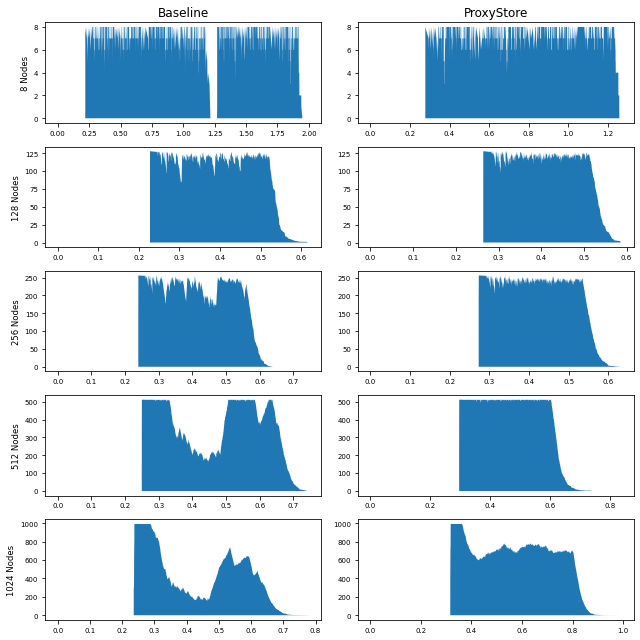

In [86]:
fig, axs = plt.subplots(5, 2, figsize=(9, 9)) #, sharex=True)

for x, (kind, kind_runs) in enumerate(runs.items()):
    for y, (nodes, run_path) in enumerate(kind_runs.items()):
        print(x, y, kind, nodes, run_path)
        utilization = pd.read_csv(os.path.join(run_path, 'processed-results/utilization.csv'))
        
        for n, task_type in [(8, 'training'), (20, 'inference'), (nodes, 'simulation')]:
            upercent = compute_utilization(utilization, [task_type], False) / n
            print(task_type, upercent)
            
        task_types = ['simulation']
        for i, task_type in enumerate(task_types):
            other_types = utilization[task_types[:i]].sum(axis=1)
            axs[y, x].fill_between(utilization['walltime'] / 3600, other_types, utilization[task_type] + other_types)
        
        if x == 0:
            axs[y, x].set_ylabel(f'{nodes} Nodes')
    
    axs[0, x].set_title(kind)
    
fig.tight_layout()
fig.savefig('figures/resource-utilization-scaling.pdf')

In [91]:
for x, (kind, kind_runs) in enumerate(runs.items()):
    gpu_utilizations = []
    cpu_utilizations = []

    for y, (nodes, run_path) in enumerate(kind_runs.items()):
        utilization = pd.read_csv(os.path.join(run_path, 'processed-results/utilization.csv'))
        
        gpu_utilizations.append(compute_utilization(utilization, ['training', 'inference'], True) / 20)
        cpu_utilizations.append(compute_utilization(utilization, ['simulation'], True) / nodes)
        
    print(f'{kind} CPU util: {cpu_utilizations}')
    print(f'{kind} GPU util: {gpu_utilizations}')

Baseline CPU util: [0.8646902807438533, 0.9269573068818762, 0.8966170705131524, 0.7744384621092077, 0.5054420692137886]
Baseline GPU util: [0.6796688040980168, 0.6830119733745553, 0.6885930245770308, 0.6468972488583706, 0.6319716190305118]
ProxyStore CPU util: [0.9037363629501167, 0.9452118492686217, 0.9469055766535985, 0.9966119531980637, 0.724352640451033]
ProxyStore GPU util: [0.7997412334690767, 0.7926567447094113, 0.8052310308176625, 0.7954557628130213, 0.7549243745886568]


In [88]:
for x, (kind, kind_runs) in enumerate(runs.items()):
    for y, (nodes, run_path) in enumerate(kind_runs.items()):
        print(kind, nodes)
        results = pd.read_json(os.path.join(run_path, 'simulation-results.json'), lines=True)
        # results.sort_values('time_compute_started', inplace=True, ignore_index=True)
        results.sort_values('time_result_sent', inplace=True, ignore_index=True)
        
        # x = results['time_result_sent'] - results['time_compute_ended']
        # print(results['time_result_sent'])
        # print(x.mean(), x.std())
        diffs_a = results['time_result_sent'].shift(-1) - results['time_result_sent']
        print(diffs_a.min())

Baseline 8
0.05176806449890137
Baseline 128
0.006681919097900391
Baseline 256
0.0049169063568115234
Baseline 512
0.0045909881591796875
Baseline 1024
0.003339052200317383
ProxyStore 8
0.003551006317138672
ProxyStore 128
0.0008890628814697266
ProxyStore 256
0.0007100105285644531
ProxyStore 512
0.0006160736083984375
ProxyStore 1024
0.0006241798400878906
